In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep

In [2]:
from typing import Union

import numpy as np
import xarray as xr

SupportedTypes = Union[np.ndarray, xr.DataArray]
d2r = 1.74532925199432957692369e-02


def rad_lat_wgs84(lat: SupportedTypes, ):
    '''
    The radius calculation for the wgs84 ellipsoid uses a taylor series from
    radius = ((a*cos(lat))**2+(b*sin(lat))**2)**(1/2)
    The taylor series is the radius of the elipsoid for a given latitude
    This is accurate to within floating point errora

    note: This doesn't need to be a taylor series, though the taylor series
    was a step for the arc_lat_wgs84 function to avoid the eliptic integral
    '''
    return \
        8.05993093251779959604912e-107 * lat ** 48 - \
        1.26581811418535723456176e-102 * lat ** 46 - \
        9.10951565776720242021392e-98 * lat ** 44 + \
        7.49821836126201522491765e-93 * lat ** 42 - \
        2.27271626922827622448519e-88 * lat ** 40 - \
        2.71379394439952534826763e-84 * lat ** 38 + \
        6.14832871773468827219624e-79 * lat ** 36 - \
        2.84993185787053811467259e-74 * lat ** 34 + \
        3.04677525449067422497153e-70 * lat ** 32 + \
        4.32285294849656618043972e-65 * lat ** 30 - \
        3.09781963775152747156702e-60 * lat ** 28 + \
        8.20657704323096444142572e-56 * lat ** 26 + \
        2.18501284875664232841136e-51 * lat ** 24 - \
        3.14445926697498412770696e-46 * lat ** 22 + \
        1.33970531285992980064454e-41 * lat ** 20 - \
        3.64729257084431972115219e-38 * lat ** 18 - \
        3.19397401776292877914625e-32 * lat ** 16 + \
        2.09755935705627800528960e-27 * lat ** 14 - \
        3.93234660296994989005722e-23 * lat ** 12 - \
        4.67346944715944948938249e-18 * lat ** 10 + \
        5.23053397296821359502194e-13 * lat ** 8 - \
        2.61499198791487361911660e-08 * lat ** 6 + \
        6.57016735969856188450312e-04 * lat ** 4 - \
        6.50322744547926518806010e+00 * lat ** 2 + \
        6378137.0


def arc_lat_wgs84(lat: SupportedTypes, ):
    '''
    The arc length calculation for the wgs84 ellipsoid uses a taylor series from
    radius = ((a*cos(lat))**2+(b*sin(lat))**2)**(1/2)
    The integral of the radius taylor series gives an arc length taylor series
    The taylor series is the distance from the equator to a given latitude
    This is accurate to within floating point error
    
    note: This needs to be a taylor series to avoid the eliptic integral
    '''
    return \
        2.87086392358719396475614e-110 * lat ** 49 - \
        4.70057315402553703681995e-106 * lat ** 47 - \
        3.53313425533365879608994e-101 * lat ** 45 + \
        3.04345577761664668327703e-96 * lat ** 43 - \
        9.67472728333544072524681e-92 * lat ** 41 - \
        1.21447793719117046293341e-87 * lat ** 39 + \
        2.90023188160517270041180e-82 * lat ** 37 - \
        1.42116269649485608032749e-77 * lat ** 35 + \
        1.61140181088334593373753e-73 * lat ** 33 + \
        2.43380700099386902295507e-68 * lat ** 31 - \
        1.86438456247248912270599e-63 * lat ** 29 + \
        5.30488110085042076590693e-59 * lat ** 27 + \
        1.52542673636737189511924e-54 * lat ** 25 - \
        2.38613771319829866779682e-49 * lat ** 23 + \
        1.11344136742221455419521e-44 * lat ** 21 - \
        3.35038232340852202916191e-41 * lat ** 19 - \
        3.27913899018323295027126e-35 * lat ** 17 + \
        2.44062113577649370926265e-30 * lat ** 15 - \
        5.27941504241845042397655e-26 * lat ** 13 - \
        7.41522084948104995730556e-21 * lat ** 11 + \
        1.01433377184128234589268e-15 * lat ** 9 - \
        6.52003144319804471773524e-11 * lat ** 7 + \
        2.29342105667605006614878e-06 * lat ** 5 - \
        3.78342436432244021373642e-02 * lat ** 3 + \
        111319.490793273572647713 * lat


def arc_lon_wgs84(
    lon: SupportedTypes,
    lat: SupportedTypes,
):
    '''
    The arc length calculation for the wgs84 ellipsoid uses a taylor series from
    radius = ((a*cos(lat))**2+(b*sin(lat))**2)**(1/2)
    The taylor series is the radius of the elipsoid for a given latitude
    This is accurate to within floating point error

    note: This doesn't need to be a taylor series, though the taylor series
    was a step for the arc_lat_wgs84 function to avoid the eliptic integral
    '''
    return rad_lat_wgs84(lat) * np.cos(lat * d2r) * lon * d2r

def grad_wgs84_xr(
    data: SupportedTypes,
    wrap_longitude: bool = True,
): 
    lon2d, lat2d= np.meshgrid(data.coords['lon'], data.coords['lat'])
    return grad_wgs84(data.values, lon2d, lat2d)
    

def grad_wgs84(
    data: SupportedTypes,
    longitude: SupportedTypes,
    latitude: SupportedTypes,
    wrap_longitude: bool = True,
):
    if wrap_longitude:
        datapad = np.pad(data, ((0, 0), (1, 1)), mode='wrap')
        lonpad = np.pad(longitude, ((0, 0), (1, 1)), mode='wrap')
        lonpad[:, 0] = lonpad[:, 0] - 360
        lonpad[:, -1] = lonpad[:, -1] + 360
        latpad = np.pad(latitude, ((0, 0), (1, 1)), mode='wrap')
    else:
        datapad = np.pad(
            data,
            ((0, 0), (1, 1)),
            mode='constant',
            constant_values=np.nan,
        )
        lonpad = np.pad(
            longitude,
            ((0, 0), (1, 1)),
            mode='constant',
            constant_values=np.nan,
        )
        latpad = np.pad(
            latitude,
            ((0, 0), (1, 1)),
            mode='constant',
            constant_values=np.nan,
        )

    datapad = np.pad(
        datapad,
        ((1, 1), (0, 0)),
        mode='constant',
        constant_values=np.nan,
    )
    lonpad = np.pad(
        lonpad,
        ((1, 1), (0, 0)),
        mode='constant',
        constant_values=np.nan,
    )
    latpad = np.pad(
        latpad,
        ((1, 1), (0, 0)),
        mode='constant',
        constant_values=np.nan,
    )

    arclonpad = arc_lon_wgs84(lonpad, latpad)
    arclatpad = arc_lat_wgs84(latpad)

    lonresult = np.zeros(data.shape)
    latresult = np.zeros(data.shape)

    for latloc in range(1, datapad.shape[0] - 1):
        for lonloc in range(1, datapad.shape[1] - 1):
            lonbac = (datapad[latloc, lonloc] - datapad[latloc, lonloc - 1]) / \
                     (arclonpad[latloc, lonloc] - arclonpad[latloc, lonloc - 1])
            lonfor = (datapad[latloc, lonloc + 1] - datapad[latloc, lonloc]) / \
                     (arclonpad[latloc, lonloc + 1] - arclonpad[latloc, lonloc])
            if not np.isnan(lonbac) and not np.isnan(lonfor):
                longrad = (lonbac + lonfor) / 2
            elif not np.isnan(lonbac):
                longrad = lonbac
            elif not np.isnan(lonfor):
                longrad = lonfor
            else:
                longrad = np.nan
            lonresult[latloc - 1, lonloc - 1] = longrad

            latbac = (datapad[latloc, lonloc] - datapad[latloc - 1, lonloc]) / \
                     (arclatpad[latloc, lonloc] - arclatpad[latloc - 1, lonloc])
            latfor = (datapad[latloc + 1, lonloc] - datapad[latloc, lonloc]) / \
                     (arclatpad[latloc + 1, lonloc] - arclatpad[latloc, lonloc])
            if not np.isnan(latbac) and not np.isnan(latfor):
                latgrad = (latbac + latfor) / 2
            elif not np.isnan(latbac):
                latgrad = latbac
            elif not np.isnan(latfor):
                latgrad = latfor
            else:
                latgrad = np.nan
            latresult[latloc - 1, lonloc - 1] = latgrad

    return [lonresult, latresult]


In [3]:
import scipy.special as sspecial
import math as ma

num_lon = 720
num_lat =360

lat = np.linspace(90, -90, num_lat)
lon = np.linspace(0, 360 -360/num_lon, num_lon)

lon2d, lat2d= np.meshgrid(lon, lat)


default_max_harm = 23  # 300 harmonics from 0,0 to 23,23
max_harm = default_max_harm

mlist = []
nlist = []
harm_data = []
for nvalue in range(max_harm + 1):
    for mvalue in range(nvalue + 1):
        mlist.append(mvalue)
        nlist.append(nvalue)
        harm_data.append((np.random.random()*2-1)/(nvalue+1)**1.5)
        if mvalue!=0:
            harm_data[-1] = harm_data[-1]+ ((1j*(np.random.random()*2-1))/(nvalue+1)**1.5)

m = np.array(mlist)
n = np.array(nlist)

harm_data = np.array(harm_data)

theta = np.linspace(0, ma.tau -ma.tau/num_lon, num_lon)
phi = np.linspace(0 , ma.pi, num_lat)
theta, phi = np.meshgrid(theta, phi)

m = np.expand_dims(m, axis=(1, 2))
n = np.expand_dims(n, axis=(1, 2))
harm_data = np.expand_dims(harm_data, axis=(1, 2))
theta = np.expand_dims(theta, axis=(0))
phi = np.expand_dims(phi, axis=(0))

sphere_noise = np.sum(
        np.multiply(sspecial.sph_harm(m, n, theta, phi).real, harm_data.real),
        axis=(0),
    ) + np.sum(
        np.multiply(sspecial.sph_harm(m, n, theta, phi).imag, harm_data.imag),
        axis=(0),
    )

In [4]:
sphere_noise_xr  = xr.DataArray(sphere_noise, dims=['lat','lon'], coords={'lon':lon, 'lat':lat}).chunk((100)).compute()

In [5]:
land_shp_fname = shpreader.natural_earth(resolution='50m', category='physical', name='land')
land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

lake_shp_fname = shpreader.natural_earth(resolution='50m', category='physical', name='lakes')
lake_geom = unary_union(list(shpreader.Reader(lake_shp_fname).geometries()))
lake = prep(lake_geom)


def watermask(data,lon_a, lat_a, land, lake):
    res = data.copy()
    lon_a = lon_a -180
    for lat in range(data.shape[0]):
        for lon in range(data.shape[1]):
            if land.contains(sgeom.Point(lon_a[lat,lon], lat_a[lat,lon])) and not lake.contains(sgeom.Point(lon_a[lat,lon], lat_a[lat,lon])):
                res[lat,lon-int(data.shape[1]/2)] = np.nan
    return res
sphere_noise_water = watermask(sphere_noise_xr,lon2d,lat2d,land,lake)

In [6]:
arc_lon = arc_lon_wgs84(lon2d, lat2d)
arc_lat = arc_lat_wgs84(lat2d)

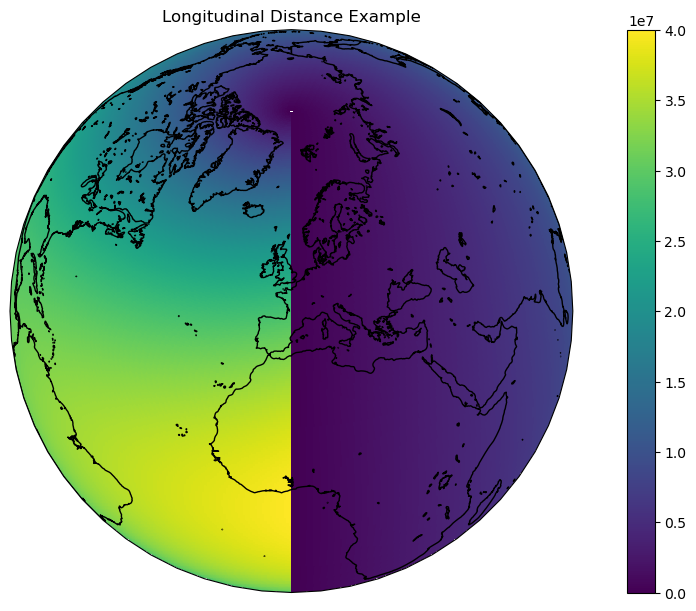

In [7]:
fig = plt.figure(dpi=100,figsize=(12,6),constrained_layout=True)
ax = plt.axes(projection=ccrs.Orthographic(0, 45))
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m'), edgecolor='black', facecolor='none')
ax.add_feature(cf.NaturalEarthFeature('physical', 'lakes', '50m'), edgecolor='black', facecolor='none')
# ax.add_feature(cf.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m'),edgecolor='black', facecolor='none' )
plt.imshow(arc_lon, interpolation='none',extent=[0,360,-90,90], origin='upper', transform=ccrs.PlateCarree())
plt.colorbar()
plt.title('Longitudinal Distance Example')
plt.show()

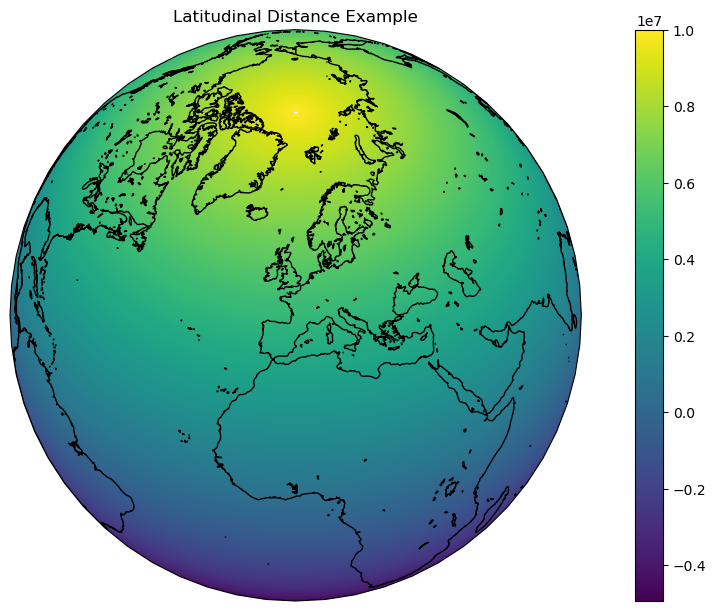

In [8]:
fig = plt.figure(dpi=100,figsize=(12,6),constrained_layout=True)
ax = plt.axes(projection=ccrs.Orthographic(0, 45))
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m'), edgecolor='black', facecolor='none')
ax.add_feature(cf.NaturalEarthFeature('physical', 'lakes', '50m'), edgecolor='black', facecolor='none')
# ax.add_feature(cf.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m'),edgecolor='black', facecolor='none' )
plt.imshow(arc_lat, interpolation='none',extent=[0,360,-90,90], origin='upper', transform=ccrs.PlateCarree())
plt.colorbar()
plt.title('Latitudinal Distance Example')
plt.show()

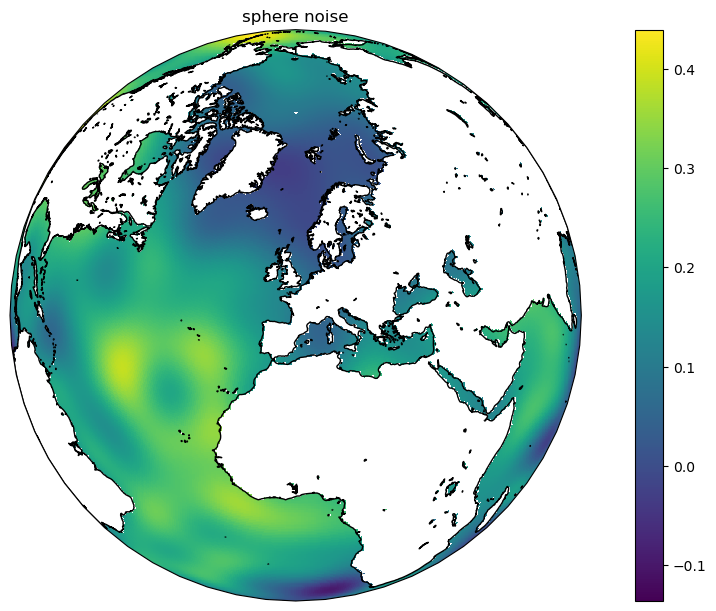

In [9]:
fig = plt.figure(dpi=100,figsize=(12,6),constrained_layout=True)
ax = plt.axes(projection=ccrs.Orthographic(0, 45))
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m'), edgecolor='black', facecolor='none')
ax.add_feature(cf.NaturalEarthFeature('physical', 'lakes', '50m'), edgecolor='black', facecolor='none')
# ax.add_feature(cf.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m'),edgecolor='black', facecolor='none' )
plt.imshow(sphere_noise_water, interpolation='none',extent=[0,360,-90,90], origin='upper', transform=ccrs.PlateCarree())
plt.colorbar()
plt.title('sphere noise')
plt.show()

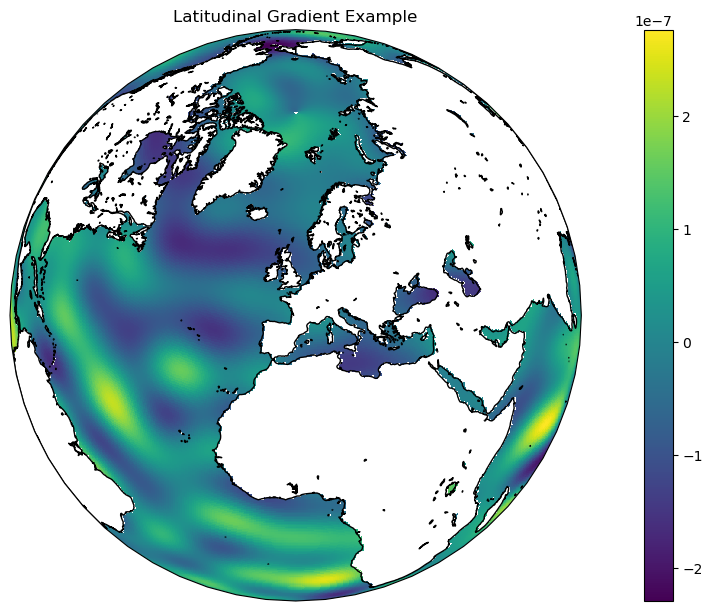

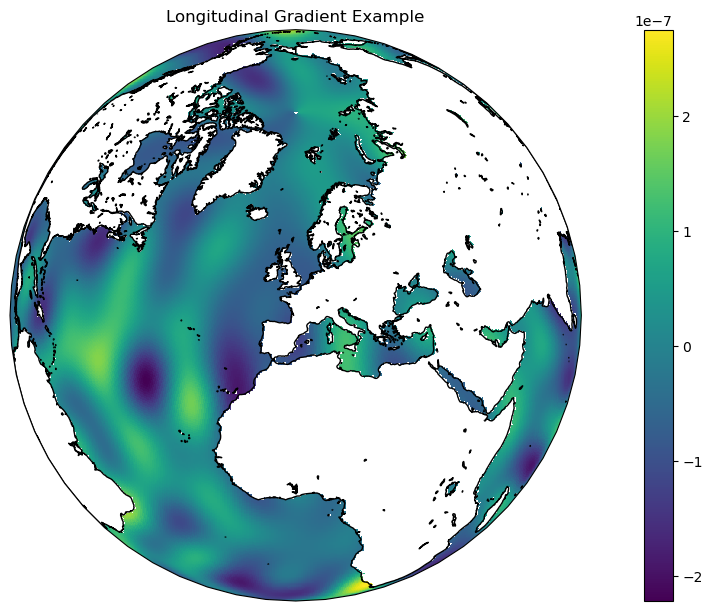

In [10]:
# grads = grad_wgs84(sphere_noise_water, lon, lat, wrap_longitude=True)
grads = grad_wgs84_xr(sphere_noise_water, wrap_longitude=True)


fig = plt.figure(dpi=100,figsize=(12,6),constrained_layout=True)
ax = plt.axes(projection=ccrs.Orthographic(0, 45))
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m'), edgecolor='black', facecolor='none')
ax.add_feature(cf.NaturalEarthFeature('physical', 'lakes', '50m'), edgecolor='black', facecolor='none')
# ax.add_feature(cf.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m'),edgecolor='black', facecolor='none' )
plt.imshow(grads[1], interpolation='none',extent=[0,360,-90,90], origin='upper', transform=ccrs.PlateCarree())
plt.colorbar()
plt.title('Latitudinal Gradient Example')
plt.show()

fig = plt.figure(dpi=100,figsize=(12,6),constrained_layout=True)
ax = plt.axes(projection=ccrs.Orthographic(0, 45))
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m'), edgecolor='black', facecolor='none')
ax.add_feature(cf.NaturalEarthFeature('physical', 'lakes', '50m'), edgecolor='black', facecolor='none')
# ax.add_feature(cf.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m'),edgecolor='black', facecolor='none' )
plt.imshow(grads[0], interpolation='none',extent=[0,360,-90,90], origin='upper', transform=ccrs.PlateCarree())
plt.colorbar()
plt.title('Longitudinal Gradient Example')
plt.show()

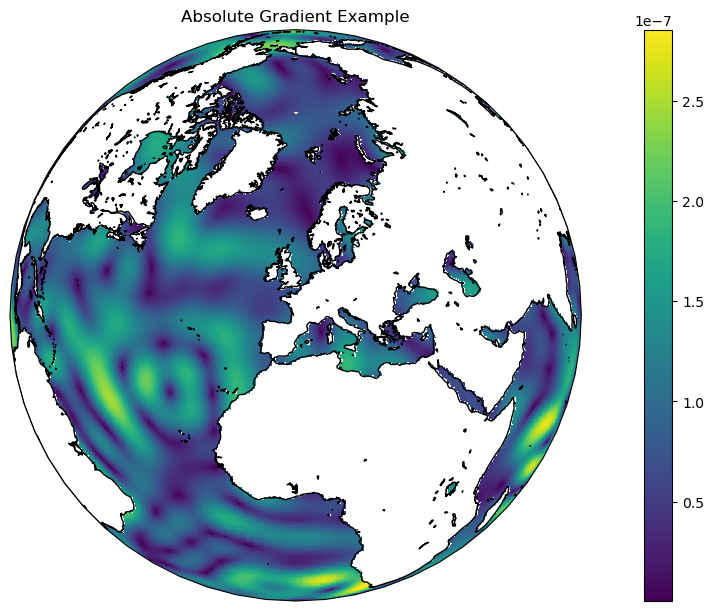

In [11]:
fig = plt.figure(dpi=100,figsize=(12,6),constrained_layout=True)
ax = plt.axes(projection=ccrs.Orthographic(0, 45))
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m'), edgecolor='black', facecolor='none')
ax.add_feature(cf.NaturalEarthFeature('physical', 'lakes', '50m'), edgecolor='black', facecolor='none')
# ax.add_feature(cf.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m'),edgecolor='black', facecolor='none' )
plt.imshow(np.sqrt(grads[0]**2+grads[1]**2), interpolation='none',extent=[0,360,-90,90], origin='upper', transform=ccrs.PlateCarree())
plt.colorbar()
plt.title('Absolute Gradient Example')
plt.show()

In [12]:
print(sphere_noise)

[[0.09023419 0.09023419 0.09023419 ... 0.09023419 0.09023419 0.09023419]
 [0.08673472 0.08672041 0.08670635 ... 0.08677922 0.08676413 0.08674929]
 [0.08304429 0.08301457 0.08298537 ... 0.08313664 0.08310533 0.08307455]
 ...
 [0.04210399 0.0420629  0.04202185 ... 0.04222735 0.04218622 0.04214509]
 [0.04289541 0.04287742 0.04285946 ... 0.04294953 0.04293147 0.04291342]
 [0.04353716 0.04353716 0.04353716 ... 0.04353716 0.04353716 0.04353716]]


In [13]:
lats = np.arange(-200,200,1/1000)

In [14]:
(20003931.458625175-20015114.442035925)

-11182.983410749584

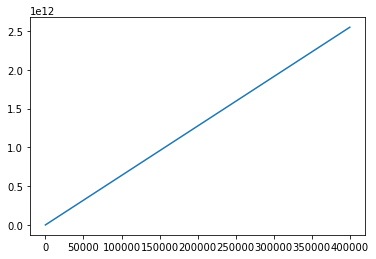

In [15]:
plt.plot(np.cumsum(rad_lat_wgs84(lats)))

In [16]:
temp = sphere_noise
temp[1,10] = np.nan
temp[1,:]+sphere_noise[2,:]

array([0.16977901, 0.16973497, 0.16969173, 0.16964928, 0.16960764,
       0.1695668 , 0.16952678, 0.16948757, 0.16944918, 0.16941161,
              nan, 0.16933896, 0.16930388, 0.16926963, 0.16923623,
       0.16920367, 0.16917195, 0.16914109, 0.16911107, 0.16908191,
       0.1690536 , 0.16902616, 0.16899958, 0.16897387, 0.16894902,
       0.16892504, 0.16890194, 0.16887971, 0.16885835, 0.16883788,
       0.16881829, 0.16879958, 0.16878176, 0.16876482, 0.16874877,
       0.16873361, 0.16871935, 0.16870597, 0.1686935 , 0.16868191,
       0.16867123, 0.16866144, 0.16865256, 0.16864457, 0.16863748,
       0.1686313 , 0.16862602, 0.16862164, 0.16861817, 0.1686156 ,
       0.16861394, 0.16861319, 0.16861333, 0.16861439, 0.16861635,
       0.16861922, 0.16862299, 0.16862767, 0.16863326, 0.16863975,
       0.16864715, 0.16865545, 0.16866466, 0.16867477, 0.16868578,
       0.16869769, 0.16871051, 0.16872423, 0.16873885, 0.16875436,
       0.16877077, 0.16878808, 0.16880629, 0.16882539, 0.16884

In [17]:
81-57

24

In [18]:
np.float128(arc_lat_wgs84(90))*4

40007862.91725088656

In [19]:
rad_lat_wgs84(90)

6356752.314245179

In [20]:
20*2.54


50.8

In [21]:
p11 = [arc_lat_wgs84(70),arc_lon_wgs84(0,70),rad_lat_wgs84(70)]
p12 = [arc_lat_wgs84(80),arc_lon_wgs84(90,80),rad_lat_wgs84(80)]

In [22]:
((p11[0]-p12[0])**2+(p11[1]-p12[1])**2)**0.5/(p11[2]+p12[2])/2

0.08094764290924014

In [23]:
p21 = [arc_lat_wgs84(10),arc_lon_wgs84(0,10),rad_lat_wgs84(10)]
p22 = [arc_lat_wgs84(20),arc_lon_wgs84(20,20),rad_lat_wgs84(20)]

In [24]:
((p21[0]-p22[0])**2+(p21[1]-p22[1])**2)**0.5/(p21[2]+p22[2])/2

0.0928792682028711

In [25]:
720*360

259200